In [1]:
# Author Bereket Kebede, Graduate Student
# Neural Networks -  Assignment #4 - University of Memphis. Fall 2021
# Question #1, Stacked RNN, LSTM, GRU
# Last updated - Oct 26, 2021


In [2]:
#####################################################################################
# Import necessary libraries

import numpy as np
from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import os

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from tensorflow.keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

In [3]:
#####################################################################################
# Allow Memory Growth

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [4]:
#####################################################################################
# Load Data


def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()
 
    return data.split('\n')

In [5]:
#####################################################################################
# Row Data Reading

# Load English data
english_sentences = load_data('small_vocab_en.txt')
# Load French data
french_sentences = load_data('small_vocab_fr.txt')

print('Dataset Loaded')

Dataset Loaded


In [6]:
#####################################################################################
# Display Sample data

for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


In [7]:
#####################################################################################
# Tokenize text

def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    x_tk = Tokenizer(char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [8]:
#####################################################################################
# Add padding

def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

#tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


In [9]:
#####################################################################################
# Pre-process data

def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


In [10]:
#####################################################################################
# logits back to text converter

def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [11]:
#####################################################################################
# Define simple RNN model

def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate = 1e-3
    input_seq = Input(input_shape[1:])
    rnn = GRU(64, return_sequences = True)(input_seq)
    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    
    return model


# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
print(tmp_x.shape[1:])

(21, 1)


In [12]:
#####################################################################################
# Train the simple RNN Neural Network

simple_rnn_model = simple_model(tmp_x.shape,max_french_sequence_length,english_vocab_size,french_vocab_size)

simple_rnn_model.summary()

simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=16, epochs=10, validation_split=0.2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21, 1)]           0         
_________________________________________________________________
gru (GRU)                    (None, 21, 64)            12864     
_________________________________________________________________
time_distributed (TimeDistri (None, 21, 344)           22360     
_________________________________________________________________
activation (Activation)      (None, 21, 344)           0         
Total params: 35,224
Trainable params: 35,224
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6893/6893 [==============================] - 23s 3ms/step - loss: 1.5036 - accuracy: 0.6147 - val_loss: nan - val_accuracy: 0.6471
Epoch 2/10
6893/6893 [==============================] - 20s 3ms/step - loss: 1.1667 - accuracy: 0.6568 - val_loss

In [13]:
#####################################################################################
# Test the simple RNN network

prediction = simple_rnn_model.predict(tmp_x[:1])
print(logits_to_text(prediction[0], french_tokenizer))

new jersey est parfois chaud en mois et il est chaud en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [14]:
#####################################################################################
# Define stacked RNN model

def stacked_rnn(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate = 1e-3
    print(input_shape)
    
    model = Sequential()
    model.add(SimpleRNN(50, input_shape = input_shape[1:], return_sequences = True))   # return_sequences parameter has to be set True to stack
    model.add(SimpleRNN(50, return_sequences = True))
    model.add(Dense(french_vocab_size, activation='softmax'))

    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    
    return model


In [15]:
#####################################################################################
# Train stacked RNN model

stacked_rnn_model = stacked_rnn(tmp_x.shape,max_french_sequence_length,english_vocab_size,french_vocab_size)

stacked_rnn_model.summary()

history_1 = stacked_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=16, epochs=10, validation_split=0.2)

(137861, 21, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 21, 50)            2600      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 21, 50)            5050      
_________________________________________________________________
dense_1 (Dense)              (None, 21, 344)           17544     
Total params: 25,194
Trainable params: 25,194
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6893/6893 [==============================] - 246s 36ms/step - loss: 1.4510 - accuracy: 0.6178 - val_loss: nan - val_accuracy: 0.6489
Epoch 2/10
6893/6893 [==============================] - 241s 35ms/step - loss: 1.1346 - accuracy: 0.6663 - val_loss: nan - val_accuracy: 0.6945
Epoch 3/10
6893/6893 [==============================] - 245s 35ms/step - loss:

In [16]:
#####################################################################################
# Display ten machine translation results using stacked RNN

from numpy import zeros, newaxis
b = tmp_x[newaxis, :, :, :]
for i in range(1,11):
    prediction = stacked_rnn_model.predict(b[:,i,:,:])
    print(logits_to_text(prediction[0], french_tokenizer))

les états unis est généralement froid en juillet et il est généralement agréable en décembre <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
californie est généralement chaud en mois et il est généralement généralement en l' <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
les états unis est parfois doux en printemps et il est froid en juillet <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
votre fruit aimé moins aimé la raisin mais son moins aimé est la <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
son fruit préféré est la raisin mais votre favori est la raisin <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
paris est calme en décembre mais il est généralement froid en juillet <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
new jersey est occupé en printemps et il est jamais tranquille en mars <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
leurs fruits aimé moins aimé la citron mais son moins aimé est la raisin <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
les états unis est parfois occupé en

Plotting training accuracy



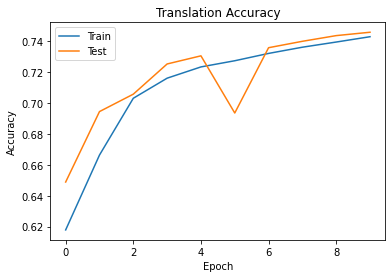

In [21]:
#####################################################################################
# Plotting training accuracy for stacked RNN

print('Plotting training accuracy\n')
plt.plot(history_1.history['accuracy'])
plt.title('Translation Accuracy')
plt.ylabel('Accuracy')
plt.plot(history_1.history['val_accuracy'])
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
#####################################################################################
# Define stacked LSTM model

from keras.layers import LSTM
def stacked_lstm(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate = 1e-3
 
    print(input_shape)

    model = Sequential()
    model.add(LSTM(50, input_shape = input_shape[1:], return_sequences = True))   # return_sequences parameter has to be set True to stack
    model.add(LSTM(50, return_sequences = True))
    model.add(Dense(french_vocab_size, activation='softmax'))

    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    
    return model


In [23]:
#####################################################################################
# Train stacked LSTM model

stacked_lstm_model = stacked_lstm(tmp_x.shape,max_french_sequence_length,english_vocab_size,french_vocab_size)

stacked_lstm_model.summary()

history_2 = stacked_lstm_model.fit(tmp_x, preproc_french_sentences, batch_size=16, epochs=10, validation_split=0.2)

(137861, 21, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 50)            20200     
_________________________________________________________________
dense_2 (Dense)              (None, 21, 344)           17544     
Total params: 48,144
Trainable params: 48,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6893/6893 [==============================] - 46s 7ms/step - loss: 1.5412 - accuracy: 0.6045 - val_loss: nan - val_accuracy: 0.6601
Epoch 2/10
6893/6893 [==============================] - 44s 6ms/step - loss: 1.0705 - accuracy: 0.6905 - val_loss: nan - val_accuracy: 0.7089
Epoch 3/10
6893/6893 [==============================] - 45s 6ms/step - loss: 0.9

In [24]:
#####################################################################################
# Display ten machine translation results using stacked LSTM

for i in range(1,11):
    prediction = stacked_lstm_model.predict(b[:,i,:,:])
    print(logits_to_text(prediction[0], french_tokenizer))

les états unis est généralement froid en juillet et il est généralement agréable en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
californie est généralement calme en l' et et est généralement généralement en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
les états unis est parfois doux en printemps et il est froid en septembre <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
votre fruit est moins aimé la raisin mais moins moins est est la <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
son fruit préféré est la pomme mais son préféré est la raisin <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
paris est relaxant en décembre mais il est généralement froid en juillet <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
new jersey est occupé en printemps et il est jamais tranquille en mars <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
notre fruit moins aimé est la pomme mais mon moins aimé est la <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
les états unis est parfois occupé en l' et

Plotting training accuracy



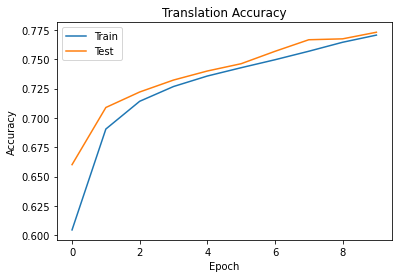

In [25]:
#####################################################################################
# Plotting training accuracy for stacked LSTM

print('Plotting training accuracy\n')
plt.plot(history_2.history['accuracy'])
plt.title('Translation Accuracy')
plt.ylabel('Accuracy')
plt.plot(history_2.history['val_accuracy'])
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
#####################################################################################
# Define stacked GRU model

from keras.layers import GRU
def stacked_gru(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate = 1e-3
    print(input_shape)

    model = Sequential()
    model.add(GRU(50, input_shape = input_shape[1:], return_sequences = True))   # return_sequences parameter has to be set True to stack
    model.add(GRU(50, return_sequences = True))
    model.add(Dense(french_vocab_size, activation='softmax'))

    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    
    return model


In [28]:
#####################################################################################
# Train stacked GRU model

stacked_gru_model = stacked_gru(tmp_x.shape,max_french_sequence_length,english_vocab_size,french_vocab_size)

stacked_gru_model.summary()

history_3 = stacked_gru_model.fit(tmp_x, preproc_french_sentences, batch_size=16, epochs=10, validation_split=0.2)

(137861, 21, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 21, 50)            7950      
_________________________________________________________________
gru_2 (GRU)                  (None, 21, 50)            15300     
_________________________________________________________________
dense_3 (Dense)              (None, 21, 344)           17544     
Total params: 40,794
Trainable params: 40,794
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6893/6893 [==============================] - 37s 5ms/step - loss: 1.4630 - accuracy: 0.6200 - val_loss: nan - val_accuracy: 0.6776
Epoch 2/10
6893/6893 [==============================] - 36s 5ms/step - loss: 1.0560 - accuracy: 0.6868 - val_loss: nan - val_accuracy: 0.6916
Epoch 3/10
6893/6893 [==============================] - 36s 5ms/step - loss: 0.9

In [29]:
#####################################################################################
# Display ten machine translation results using stacked GRU

for i in range(1,11):
    prediction = stacked_gru_model.predict(b[:,i,:,:])
    print(logits_to_text(prediction[0], french_tokenizer))

les états unis est généralement froid en juillet et il est généralement agréable en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
californie est généralement calme en mois et il est généralement calme en juin <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
les états unis est parfois doux en juin et il est froid en septembre <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
votre fruit aimé moins aimé est pomme mais son moins aimé est la citron <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
son fruit préféré est la citron mais son favori est la pomme <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
paris est calme en février mais il est généralement froid en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
new jersey est occupé en l' et il est jamais tranquille en mars <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
notre fruit aimé aimé est la chaux mais son moins aimé est la <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
les états unis est parfois occupé en janvier et il est parfois c

Plotting training accuracy



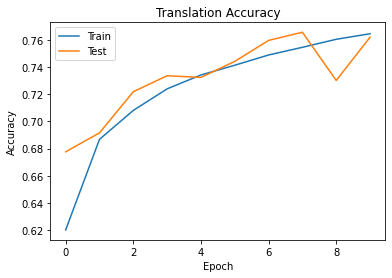

In [30]:
#####################################################################################
# Plotting training accuracy for stacked LSTM

print('Plotting training accuracy\n')
plt.plot(history_3.history['accuracy'])
plt.title('Translation Accuracy')
plt.ylabel('Accuracy')
plt.plot(history_3.history['val_accuracy'])
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()